<a href="https://colab.research.google.com/github/Jathu03/SRGAN/blob/main/SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [58]:
#path for images
train_dir = "data"

#create low resolution images
for img in os.listdir( train_dir + "/original_images"):
    img1 = cv2.imread(train_dir + "/original_images/" + img)

    img1 = cv2.resize(img1, (128,128))
    lr_img = cv2.resize(img1,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img,img1)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img)

In [5]:
#Define residual  blocks
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)    #convolution layer
    res_model = BatchNormalization(momentum = 0.5)(res_model)  #Batch Normalization
    res_model = PReLU(shared_axes = [1,2])(res_model)   #PReLU

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)  # convolution layer
    res_model = BatchNormalization(momentum = 0.5)(res_model)  #Batch Normalization

    return add([ip,res_model])   #elementwise adder

In [6]:
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)   #pixel suffler convers lr to hr
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [36]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):  #create residual block required number of times
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])    #adding functions before  layers with layers

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [37]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:  #for first block we don't have batch normalization
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model


#Descriminartor
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)  #stride =1
    d4 = discriminator_block(d3, df*2, strides=2)   #stride =2
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)  #flatten the layer
    d9 = Dense(df*16)(d8_5)  #dense layer
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [38]:
#VGG19 for feature maps
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)  #weights are imagenet and include_top is False as we use only feature extraction.

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)  #upto layer 10

In [39]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)    #content loss using VGG19

    disc_model.trainable = False
    validity = disc_model(gen_img)   #adversarial loss of generator

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [72]:
#load dataset
n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
#add images in lr_images array
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)


hr_list = os.listdir("data/hr_images")[:n]

hr_images = []
#add images in hr_images array
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [62]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test dataset
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.20, random_state=42)


#getting the shape to give as input to discriminator
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
#generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
#discriminator.summary()

vgg = build_vgg((128,128,3))   #extract features from hr_images
#print(vgg.summary())
vgg.trainable = False   # not trainable as pre-defined values are used.

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
#gan_model.summary()

In [44]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [63]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate generator and discriminator losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 89ms/step


  0%|          | 1/201 [00:34<1:55:55, 34.78s/it]

1/1 [==============================] - 0s 17ms/step


  1%|          | 2/201 [00:34<47:53, 14.44s/it]  

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 3/201 [00:35<26:12,  7.94s/it]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/201 [00:35<16:01,  4.88s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/201 [00:35<10:25,  3.19s/it]

1/1 [==============================] - 0s 91ms/step


  3%|▎         | 6/201 [00:36<07:21,  2.26s/it]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 7/201 [00:36<05:34,  1.72s/it]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 8/201 [00:37<04:27,  1.39s/it]

1/1 [==============================] - 0s 109ms/step


  4%|▍         | 9/201 [00:37<03:43,  1.16s/it]

1/1 [==============================] - 0s 101ms/step


  5%|▍         | 10/201 [00:38<03:10,  1.00it/s]

1/1 [==============================] - 0s 81ms/step


  5%|▌         | 11/201 [00:39<02:42,  1.17it/s]

1/1 [==============================] - 0s 107ms/step


  6%|▌         | 12/201 [00:39<02:26,  1.29it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 13/201 [00:40<02:02,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/201 [00:40<01:41,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 15/201 [00:40<01:21,  2.28it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/201 [00:40<01:07,  2.75it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/201 [00:40<00:57,  3.22it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 18/201 [00:41<00:50,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 19/201 [00:41<00:49,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 20/201 [00:41<00:52,  3.44it/s]

1/1 [==============================] - 0s 52ms/step


 10%|█         | 21/201 [00:42<00:57,  3.13it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█         | 22/201 [00:42<00:58,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 23/201 [00:42<00:57,  3.08it/s]

1/1 [==============================] - 0s 114ms/step


 12%|█▏        | 24/201 [00:43<01:09,  2.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/201 [00:43<01:07,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 26/201 [00:43<00:56,  3.08it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 27/201 [00:44<00:49,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 28/201 [00:44<00:43,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/201 [00:44<00:41,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 30/201 [00:44<00:37,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 31/201 [00:44<00:35,  4.75it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 32/201 [00:45<00:33,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 33/201 [00:45<00:32,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 34/201 [00:45<00:30,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 35/201 [00:45<00:31,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 36/201 [00:45<00:30,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 37/201 [00:45<00:29,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 38/201 [00:46<00:29,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 39/201 [00:46<00:28,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 40/201 [00:46<00:28,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 41/201 [00:46<00:28,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 42/201 [00:46<00:29,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 43/201 [00:46<00:28,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 44/201 [00:47<00:27,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 45/201 [00:47<00:27,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 46/201 [00:47<00:26,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 47/201 [00:47<00:27,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 48/201 [00:47<00:26,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 49/201 [00:48<00:26,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 50/201 [00:48<00:26,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 51/201 [00:48<00:25,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 52/201 [00:48<00:25,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 53/201 [00:48<00:25,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 54/201 [00:48<00:25,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 55/201 [00:49<00:24,  5.92it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 56/201 [00:49<00:24,  5.97it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 57/201 [00:49<00:24,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 58/201 [00:49<00:24,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 59/201 [00:49<00:24,  5.82it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 60/201 [00:49<00:26,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 61/201 [00:50<00:28,  4.99it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 62/201 [00:50<00:28,  4.85it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 63/201 [00:50<00:30,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 64/201 [00:50<00:30,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 65/201 [00:51<00:31,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 66/201 [00:51<00:31,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 67/201 [00:51<00:32,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 68/201 [00:51<00:31,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 69/201 [00:52<00:31,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 70/201 [00:52<00:30,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 71/201 [00:52<00:30,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 72/201 [00:52<00:30,  4.28it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 73/201 [00:53<00:30,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 74/201 [00:53<00:28,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 75/201 [00:53<00:26,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 76/201 [00:53<00:26,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 77/201 [00:53<00:25,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 78/201 [00:53<00:24,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 79/201 [00:54<00:23,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 80/201 [00:54<00:22,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 81/201 [00:54<00:22,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 82/201 [00:54<00:22,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 83/201 [00:54<00:21,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 84/201 [00:55<00:21,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 85/201 [00:55<00:21,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 86/201 [00:55<00:21,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 87/201 [00:55<00:21,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 88/201 [00:55<00:21,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 89/201 [00:55<00:20,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 90/201 [00:56<00:20,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 91/201 [00:56<00:19,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 92/201 [00:56<00:19,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 93/201 [00:56<00:19,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 94/201 [00:56<00:18,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 95/201 [00:57<00:18,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 96/201 [00:57<00:18,  5.78it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 97/201 [00:57<00:18,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 98/201 [00:57<00:18,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 99/201 [00:57<00:18,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 100/201 [00:57<00:17,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 101/201 [00:58<00:17,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 102/201 [00:58<00:17,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 103/201 [00:58<00:17,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 104/201 [00:58<00:16,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 105/201 [00:58<00:16,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 106/201 [00:58<00:16,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 107/201 [00:59<00:16,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 108/201 [00:59<00:15,  5.90it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 109/201 [00:59<00:15,  5.98it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 110/201 [00:59<00:15,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 111/201 [00:59<00:15,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 112/201 [01:00<00:15,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 113/201 [01:00<00:15,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 114/201 [01:00<00:14,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 115/201 [01:00<00:14,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 116/201 [01:00<00:14,  5.87it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 117/201 [01:00<00:17,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 118/201 [01:01<00:20,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 119/201 [01:01<00:20,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 120/201 [01:01<00:23,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 121/201 [01:02<00:24,  3.33it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 122/201 [01:02<00:24,  3.20it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 123/201 [01:02<00:21,  3.58it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 124/201 [01:03<00:19,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 125/201 [01:03<00:17,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 126/201 [01:03<00:17,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 127/201 [01:03<00:17,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 128/201 [01:03<00:17,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 129/201 [01:04<00:17,  4.03it/s]

1/1 [==============================] - 0s 89ms/step


 65%|██████▍   | 130/201 [01:04<00:22,  3.13it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▌   | 131/201 [01:05<00:26,  2.64it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 132/201 [01:05<00:28,  2.40it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 133/201 [01:06<00:31,  2.16it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 134/201 [01:06<00:31,  2.11it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 135/201 [01:07<00:29,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 136/201 [01:07<00:24,  2.65it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 137/201 [01:07<00:20,  3.08it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 138/201 [01:07<00:17,  3.51it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 139/201 [01:07<00:15,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 140/201 [01:08<00:14,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 141/201 [01:08<00:13,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 142/201 [01:08<00:12,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 143/201 [01:08<00:11,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 144/201 [01:08<00:11,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 145/201 [01:09<00:10,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 146/201 [01:09<00:10,  5.27it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 147/201 [01:09<00:10,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 148/201 [01:09<00:09,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 149/201 [01:09<00:09,  5.48it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 150/201 [01:09<00:09,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 151/201 [01:10<00:09,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 152/201 [01:10<00:08,  5.54it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 153/201 [01:10<00:08,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 154/201 [01:10<00:08,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 155/201 [01:10<00:08,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 156/201 [01:11<00:08,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 157/201 [01:11<00:07,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 158/201 [01:11<00:07,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 159/201 [01:11<00:07,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 160/201 [01:11<00:07,  5.68it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 161/201 [01:11<00:06,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 162/201 [01:12<00:06,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 163/201 [01:12<00:06,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 164/201 [01:12<00:06,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 165/201 [01:12<00:06,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 166/201 [01:12<00:06,  5.67it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 167/201 [01:13<00:07,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 168/201 [01:13<00:08,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 169/201 [01:13<00:07,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 170/201 [01:13<00:06,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 171/201 [01:13<00:05,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 172/201 [01:14<00:05,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 173/201 [01:14<00:05,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 174/201 [01:14<00:05,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 175/201 [01:14<00:04,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 176/201 [01:14<00:04,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 177/201 [01:15<00:04,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 178/201 [01:15<00:04,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 179/201 [01:15<00:03,  5.60it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 180/201 [01:15<00:03,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 181/201 [01:15<00:03,  5.61it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 182/201 [01:15<00:03,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 183/201 [01:16<00:03,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 184/201 [01:16<00:03,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 185/201 [01:16<00:02,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 186/201 [01:16<00:02,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 187/201 [01:16<00:02,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 188/201 [01:17<00:02,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 189/201 [01:17<00:02,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 190/201 [01:17<00:02,  4.40it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 191/201 [01:17<00:02,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 192/201 [01:18<00:02,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 193/201 [01:18<00:01,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 194/201 [01:18<00:01,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 195/201 [01:18<00:01,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 196/201 [01:19<00:01,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 197/201 [01:19<00:00,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 198/201 [01:19<00:00,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 199/201 [01:19<00:00,  4.12it/s]

1/1 [==============================] - 0s 81ms/step


100%|█████████▉| 200/201 [01:20<00:00,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 201/201 [01:20<00:00,  2.49it/s]


epoch: 1 g_loss: 8.162863731055303 d_loss: [5.37675942 0.87064677]


  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 1/201 [00:00<01:00,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 2/201 [00:00<00:53,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 3/201 [00:00<00:53,  3.71it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/201 [00:01<00:47,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/201 [00:01<00:44,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 6/201 [00:01<00:42,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/201 [00:01<00:40,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/201 [00:01<00:40,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/201 [00:01<00:37,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/201 [00:02<00:37,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 11/201 [00:02<00:36,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 12/201 [00:02<00:35,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 13/201 [00:02<00:35,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/201 [00:02<00:34,  5.39it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 15/201 [00:03<00:40,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 16/201 [00:03<00:42,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 17/201 [00:03<00:44,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 18/201 [00:04<00:47,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 19/201 [00:04<00:46,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/201 [00:04<00:42,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 21/201 [00:04<00:42,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 22/201 [00:04<00:44,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 23/201 [00:05<00:45,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 24/201 [00:05<00:46,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 25/201 [00:05<00:46,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 26/201 [00:06<00:46,  3.75it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 27/201 [00:06<00:42,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 28/201 [00:06<00:39,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/201 [00:06<00:36,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 30/201 [00:06<00:34,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 31/201 [00:06<00:33,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 32/201 [00:07<00:32,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 33/201 [00:07<00:31,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 34/201 [00:07<00:30,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/201 [00:07<00:30,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 36/201 [00:07<00:30,  5.40it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 37/201 [00:08<00:30,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 38/201 [00:08<00:31,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 39/201 [00:08<00:30,  5.31it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 40/201 [00:08<00:29,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 41/201 [00:08<00:29,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 42/201 [00:09<00:29,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 43/201 [00:09<00:28,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 44/201 [00:09<00:28,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/201 [00:09<00:27,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 46/201 [00:09<00:29,  5.32it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 47/201 [00:09<00:31,  4.89it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 48/201 [00:10<00:33,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 49/201 [00:10<00:33,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 50/201 [00:10<00:34,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 51/201 [00:10<00:35,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 52/201 [00:11<00:34,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 53/201 [00:11<00:34,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 54/201 [00:11<00:39,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 55/201 [00:12<00:38,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 56/201 [00:12<00:38,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 57/201 [00:12<00:37,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 58/201 [00:12<00:37,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 59/201 [00:13<00:37,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 60/201 [00:13<00:34,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 61/201 [00:13<00:32,  4.37it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 62/201 [00:13<00:30,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 63/201 [00:13<00:28,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 64/201 [00:14<00:27,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 65/201 [00:14<00:26,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 66/201 [00:14<00:25,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 67/201 [00:14<00:24,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 68/201 [00:14<00:24,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 69/201 [00:14<00:24,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 70/201 [00:15<00:23,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 71/201 [00:15<00:24,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 72/201 [00:15<00:24,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 73/201 [00:15<00:23,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 74/201 [00:15<00:23,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 75/201 [00:16<00:23,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 76/201 [00:16<00:23,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 77/201 [00:16<00:23,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 78/201 [00:16<00:23,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 79/201 [00:16<00:22,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 80/201 [00:16<00:22,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 81/201 [00:17<00:22,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 82/201 [00:17<00:21,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 83/201 [00:17<00:21,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 84/201 [00:17<00:21,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 85/201 [00:17<00:21,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 86/201 [00:18<00:21,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 87/201 [00:18<00:21,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 88/201 [00:18<00:20,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 89/201 [00:18<00:20,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 90/201 [00:18<00:21,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 91/201 [00:19<00:20,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 92/201 [00:19<00:20,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 93/201 [00:19<00:19,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 94/201 [00:19<00:20,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 95/201 [00:19<00:19,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 96/201 [00:19<00:19,  5.32it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 97/201 [00:20<00:19,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 98/201 [00:20<00:18,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 99/201 [00:20<00:18,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 100/201 [00:20<00:18,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 101/201 [00:20<00:18,  5.52it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 102/201 [00:21<00:17,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 103/201 [00:21<00:17,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 104/201 [00:21<00:17,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 105/201 [00:21<00:17,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 106/201 [00:21<00:17,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 107/201 [00:21<00:17,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 108/201 [00:22<00:16,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 109/201 [00:22<00:16,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 110/201 [00:22<00:17,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 111/201 [00:22<00:16,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 112/201 [00:22<00:16,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 113/201 [00:23<00:16,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 114/201 [00:23<00:17,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 115/201 [00:23<00:18,  4.70it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 116/201 [00:23<00:19,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 117/201 [00:24<00:19,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 118/201 [00:24<00:26,  3.10it/s]

1/1 [==============================] - 0s 152ms/step


 59%|█████▉    | 119/201 [00:25<00:42,  1.93it/s]

1/1 [==============================] - 0s 84ms/step


 60%|█████▉    | 120/201 [00:26<00:46,  1.73it/s]

1/1 [==============================] - 0s 83ms/step


 60%|██████    | 121/201 [00:26<00:45,  1.75it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 122/201 [00:27<00:44,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 123/201 [00:27<00:39,  1.98it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 124/201 [00:27<00:32,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 125/201 [00:28<00:26,  2.84it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 126/201 [00:28<00:22,  3.29it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 127/201 [00:28<00:19,  3.71it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 128/201 [00:28<00:17,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 129/201 [00:29<00:21,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 130/201 [00:29<00:22,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 131/201 [00:29<00:23,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 132/201 [00:30<00:22,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 133/201 [00:30<00:23,  2.89it/s]

1/1 [==============================] - 0s 82ms/step


 67%|██████▋   | 134/201 [00:31<00:25,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 135/201 [00:31<00:25,  2.55it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 136/201 [00:31<00:21,  2.98it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 137/201 [00:31<00:18,  3.38it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 138/201 [00:32<00:16,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 139/201 [00:32<00:15,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 140/201 [00:32<00:14,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 141/201 [00:32<00:13,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 142/201 [00:32<00:12,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 143/201 [00:33<00:11,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 144/201 [00:33<00:11,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 145/201 [00:33<00:11,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 146/201 [00:33<00:11,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 147/201 [00:33<00:11,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 148/201 [00:34<00:10,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 149/201 [00:34<00:10,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 150/201 [00:34<00:10,  5.00it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 151/201 [00:34<00:09,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 152/201 [00:34<00:09,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 153/201 [00:35<00:09,  5.18it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 154/201 [00:35<00:09,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 155/201 [00:35<00:08,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 156/201 [00:35<00:08,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 157/201 [00:35<00:08,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 158/201 [00:35<00:08,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 159/201 [00:36<00:07,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 160/201 [00:36<00:07,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 161/201 [00:36<00:07,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 162/201 [00:36<00:07,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 163/201 [00:36<00:06,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 164/201 [00:37<00:06,  5.44it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 165/201 [00:37<00:07,  5.10it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 166/201 [00:37<00:07,  4.80it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 167/201 [00:37<00:07,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 168/201 [00:38<00:07,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 169/201 [00:38<00:07,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 170/201 [00:38<00:07,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 171/201 [00:38<00:07,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 172/201 [00:38<00:06,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 173/201 [00:39<00:06,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 174/201 [00:39<00:06,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 175/201 [00:39<00:06,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 176/201 [00:39<00:06,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 177/201 [00:40<00:06,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 178/201 [00:40<00:05,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 179/201 [00:40<00:05,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 180/201 [00:40<00:04,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 181/201 [00:41<00:04,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 182/201 [00:41<00:04,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 183/201 [00:41<00:03,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 184/201 [00:41<00:03,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 185/201 [00:41<00:03,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 186/201 [00:42<00:02,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 187/201 [00:42<00:02,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 188/201 [00:42<00:02,  5.14it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 189/201 [00:42<00:02,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 190/201 [00:42<00:02,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 191/201 [00:43<00:01,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 192/201 [00:43<00:01,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 193/201 [00:43<00:01,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 194/201 [00:43<00:01,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 195/201 [00:43<00:01,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 196/201 [00:44<00:00,  5.19it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 197/201 [00:44<00:00,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 198/201 [00:44<00:00,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 199/201 [00:44<00:00,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 200/201 [00:44<00:00,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 201/201 [00:44<00:00,  4.47it/s]


epoch: 2 g_loss: 0.02579702273015841 d_loss: [2.29190709 0.84825871]


  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/201 [00:00<00:37,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 2/201 [00:00<00:36,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/201 [00:00<00:36,  5.45it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 4/201 [00:00<00:35,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/201 [00:00<00:37,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 6/201 [00:01<00:37,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/201 [00:01<00:36,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 8/201 [00:01<00:36,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 9/201 [00:01<00:35,  5.36it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 10/201 [00:01<00:36,  5.18it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 11/201 [00:02<00:36,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 12/201 [00:02<00:36,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 13/201 [00:02<00:35,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 14/201 [00:02<00:34,  5.39it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 15/201 [00:02<00:34,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 16/201 [00:03<00:34,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 17/201 [00:03<00:34,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 18/201 [00:03<00:33,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 19/201 [00:03<00:33,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 20/201 [00:03<00:32,  5.50it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 21/201 [00:03<00:32,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/201 [00:04<00:31,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 23/201 [00:04<00:31,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 24/201 [00:04<00:31,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/201 [00:04<00:31,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 26/201 [00:04<00:31,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 27/201 [00:04<00:31,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 28/201 [00:05<00:30,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 29/201 [00:05<00:30,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 30/201 [00:05<00:30,  5.55it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 31/201 [00:05<00:33,  5.04it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 32/201 [00:06<00:36,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 33/201 [00:06<00:39,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 34/201 [00:06<00:39,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 35/201 [00:06<00:41,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 36/201 [00:07<00:40,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 37/201 [00:07<00:39,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 38/201 [00:07<00:40,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 39/201 [00:07<00:40,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 40/201 [00:08<00:40,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 41/201 [00:08<00:40,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 42/201 [00:08<00:39,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 43/201 [00:08<00:39,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 44/201 [00:09<00:39,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/201 [00:09<00:36,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 46/201 [00:09<00:34,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 47/201 [00:09<00:32,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 48/201 [00:09<00:31,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 49/201 [00:10<00:30,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 50/201 [00:10<00:31,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 51/201 [00:10<00:30,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 52/201 [00:10<00:29,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 53/201 [00:10<00:28,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 54/201 [00:11<00:28,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 55/201 [00:11<00:28,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 56/201 [00:11<00:28,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 57/201 [00:11<00:27,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 58/201 [00:11<00:26,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 59/201 [00:11<00:26,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 60/201 [00:12<00:26,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 61/201 [00:12<00:26,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 62/201 [00:12<00:26,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 63/201 [00:12<00:26,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 64/201 [00:12<00:26,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 65/201 [00:13<00:27,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 66/201 [00:13<00:26,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 67/201 [00:13<00:25,  5.24it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 68/201 [00:13<00:25,  5.22it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 69/201 [00:13<00:24,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 70/201 [00:14<00:25,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 71/201 [00:14<00:25,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 72/201 [00:14<00:24,  5.27it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 73/201 [00:14<00:24,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 74/201 [00:14<00:23,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 75/201 [00:15<00:23,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 76/201 [00:15<00:23,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 77/201 [00:15<00:23,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 78/201 [00:15<00:23,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 79/201 [00:15<00:23,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 80/201 [00:15<00:22,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 81/201 [00:16<00:22,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 82/201 [00:16<00:21,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 83/201 [00:16<00:21,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 84/201 [00:16<00:21,  5.46it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 85/201 [00:16<00:21,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 86/201 [00:17<00:20,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 87/201 [00:17<00:20,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 88/201 [00:17<00:20,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 89/201 [00:17<00:21,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 90/201 [00:17<00:20,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 91/201 [00:17<00:20,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 92/201 [00:18<00:20,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 93/201 [00:18<00:20,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 94/201 [00:18<00:19,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 95/201 [00:18<00:19,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 96/201 [00:18<00:19,  5.37it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 97/201 [00:19<00:21,  4.79it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 98/201 [00:19<00:22,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 99/201 [00:19<00:23,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 100/201 [00:19<00:23,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 101/201 [00:20<00:23,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 102/201 [00:20<00:24,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 103/201 [00:20<00:23,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 104/201 [00:20<00:24,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 105/201 [00:21<00:24,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 106/201 [00:21<00:23,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 107/201 [00:21<00:23,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 108/201 [00:21<00:23,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 109/201 [00:22<00:24,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 110/201 [00:22<00:22,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 111/201 [00:22<00:21,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 112/201 [00:22<00:19,  4.51it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 113/201 [00:23<00:19,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 114/201 [00:23<00:18,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 115/201 [00:23<00:17,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 116/201 [00:23<00:17,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 117/201 [00:23<00:17,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 118/201 [00:24<00:17,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 119/201 [00:24<00:17,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 120/201 [00:24<00:16,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 121/201 [00:24<00:16,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 122/201 [00:24<00:15,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 123/201 [00:25<00:15,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 124/201 [00:25<00:15,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 125/201 [00:25<00:15,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 126/201 [00:25<00:14,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 127/201 [00:25<00:14,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 128/201 [00:26<00:14,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 129/201 [00:26<00:14,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 130/201 [00:26<00:13,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 131/201 [00:26<00:13,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 132/201 [00:26<00:13,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 133/201 [00:27<00:13,  5.13it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 134/201 [00:27<00:13,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 135/201 [00:27<00:12,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 136/201 [00:27<00:12,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 137/201 [00:27<00:12,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 138/201 [00:27<00:11,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 139/201 [00:28<00:12,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 140/201 [00:28<00:11,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 141/201 [00:28<00:11,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 142/201 [00:28<00:11,  5.17it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 143/201 [00:28<00:11,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 144/201 [00:29<00:10,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 145/201 [00:29<00:10,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 146/201 [00:29<00:10,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 147/201 [00:29<00:10,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 148/201 [00:29<00:09,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 149/201 [00:30<00:10,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 150/201 [00:30<00:10,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 151/201 [00:30<00:09,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 152/201 [00:30<00:09,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 153/201 [00:30<00:09,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 154/201 [00:31<00:09,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 155/201 [00:31<00:08,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 156/201 [00:31<00:08,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 157/201 [00:31<00:08,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 158/201 [00:31<00:08,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 159/201 [00:32<00:08,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 160/201 [00:32<00:07,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 161/201 [00:32<00:07,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 162/201 [00:32<00:08,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 163/201 [00:32<00:08,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 164/201 [00:33<00:08,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 165/201 [00:33<00:08,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 166/201 [00:33<00:08,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 167/201 [00:33<00:08,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 168/201 [00:34<00:08,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 169/201 [00:34<00:08,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 170/201 [00:34<00:07,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 171/201 [00:34<00:07,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 172/201 [00:35<00:07,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 173/201 [00:35<00:07,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 174/201 [00:35<00:06,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 175/201 [00:35<00:06,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 176/201 [00:36<00:06,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 177/201 [00:36<00:05,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 178/201 [00:36<00:05,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 179/201 [00:36<00:04,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 180/201 [00:37<00:04,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 181/201 [00:37<00:04,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 182/201 [00:37<00:03,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 183/201 [00:37<00:03,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 184/201 [00:37<00:03,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 185/201 [00:38<00:03,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 186/201 [00:38<00:03,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 187/201 [00:38<00:02,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 188/201 [00:38<00:02,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 189/201 [00:38<00:02,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 190/201 [00:39<00:02,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 191/201 [00:39<00:02,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 192/201 [00:39<00:01,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 193/201 [00:39<00:01,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 194/201 [00:39<00:01,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 195/201 [00:40<00:01,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 196/201 [00:40<00:01,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 197/201 [00:40<00:00,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 198/201 [00:40<00:00,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 199/201 [00:40<00:00,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 200/201 [00:41<00:00,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 201/201 [00:41<00:00,  4.86it/s]


epoch: 3 g_loss: 0.012805313431421545 d_loss: [1.03787091 0.90547264]


  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/201 [00:00<00:43,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 2/201 [00:00<00:41,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 3/201 [00:00<00:41,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 4/201 [00:00<00:39,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 5/201 [00:01<00:38,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/201 [00:01<00:38,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 7/201 [00:01<00:38,  5.10it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 8/201 [00:01<00:38,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/201 [00:01<00:38,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 10/201 [00:02<00:38,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 11/201 [00:02<00:37,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/201 [00:02<00:37,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 13/201 [00:02<00:37,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 14/201 [00:02<00:37,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 15/201 [00:03<00:37,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 16/201 [00:03<00:36,  5.01it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 17/201 [00:03<00:36,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 18/201 [00:03<00:37,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 19/201 [00:03<00:36,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 20/201 [00:04<00:36,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 21/201 [00:04<00:35,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 22/201 [00:04<00:35,  5.08it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 23/201 [00:04<00:37,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 24/201 [00:04<00:40,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 25/201 [00:05<00:42,  4.15it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 26/201 [00:05<00:42,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 27/201 [00:05<00:44,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 28/201 [00:05<00:44,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 29/201 [00:06<00:44,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 30/201 [00:06<00:44,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 31/201 [00:06<00:43,  3.87it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 32/201 [00:07<00:43,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 33/201 [00:07<00:43,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 34/201 [00:07<00:43,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 35/201 [00:07<00:42,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 36/201 [00:08<00:41,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 37/201 [00:08<00:38,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 38/201 [00:08<00:36,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 39/201 [00:08<00:35,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 40/201 [00:08<00:34,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 41/201 [00:09<00:33,  4.83it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 42/201 [00:09<00:32,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 43/201 [00:09<00:31,  4.99it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 44/201 [00:09<00:31,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/201 [00:09<00:31,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 46/201 [00:10<00:31,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 47/201 [00:10<00:30,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 48/201 [00:10<00:29,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 49/201 [00:10<00:29,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 50/201 [00:10<00:28,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 51/201 [00:10<00:29,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 52/201 [00:11<00:29,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 53/201 [00:11<00:29,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 54/201 [00:11<00:28,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 55/201 [00:11<00:28,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 56/201 [00:11<00:28,  5.03it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 57/201 [00:12<00:27,  5.16it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 58/201 [00:12<00:27,  5.22it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 59/201 [00:12<00:26,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 60/201 [00:12<00:26,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 61/201 [00:12<00:26,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 62/201 [00:13<00:26,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 63/201 [00:13<00:26,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 64/201 [00:13<00:25,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 65/201 [00:13<00:25,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 66/201 [00:13<00:25,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 67/201 [00:14<00:25,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 68/201 [00:14<00:25,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 69/201 [00:14<00:24,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 70/201 [00:14<00:24,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 71/201 [00:14<00:24,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 72/201 [00:14<00:25,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 73/201 [00:15<00:24,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 74/201 [00:15<00:24,  5.25it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 75/201 [00:15<00:23,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 76/201 [00:15<00:23,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 77/201 [00:15<00:23,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 78/201 [00:16<00:23,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 79/201 [00:16<00:22,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 80/201 [00:16<00:22,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 81/201 [00:16<00:22,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 82/201 [00:16<00:22,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 83/201 [00:17<00:22,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 84/201 [00:17<00:22,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 85/201 [00:17<00:21,  5.32it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 86/201 [00:17<00:22,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 87/201 [00:17<00:22,  4.99it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 88/201 [00:18<00:23,  4.72it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 89/201 [00:18<00:25,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 90/201 [00:18<00:25,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 91/201 [00:18<00:25,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 92/201 [00:19<00:26,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 93/201 [00:19<00:27,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 94/201 [00:19<00:27,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 95/201 [00:19<00:27,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 96/201 [00:20<00:27,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 97/201 [00:20<00:27,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 98/201 [00:20<00:27,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 99/201 [00:21<00:27,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 100/201 [00:21<00:28,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 101/201 [00:21<00:27,  3.65it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 102/201 [00:21<00:25,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 103/201 [00:21<00:23,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 104/201 [00:22<00:22,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 105/201 [00:22<00:21,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 106/201 [00:22<00:20,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 107/201 [00:22<00:19,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 108/201 [00:22<00:18,  4.91it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 109/201 [00:23<00:18,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 110/201 [00:23<00:18,  4.99it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 111/201 [00:23<00:18,  4.88it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 112/201 [00:23<00:17,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 113/201 [00:23<00:17,  5.05it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 114/201 [00:24<00:17,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 115/201 [00:24<00:17,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 116/201 [00:24<00:17,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 117/201 [00:24<00:16,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 118/201 [00:24<00:16,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 119/201 [00:25<00:16,  4.96it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 120/201 [00:25<00:16,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 121/201 [00:25<00:15,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 122/201 [00:25<00:15,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 123/201 [00:25<00:15,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 124/201 [00:26<00:15,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 125/201 [00:26<00:15,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 126/201 [00:26<00:15,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 127/201 [00:26<00:15,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 128/201 [00:27<00:15,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 129/201 [00:27<00:15,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 130/201 [00:27<00:14,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 131/201 [00:27<00:14,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 132/201 [00:27<00:13,  4.94it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 133/201 [00:28<00:13,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 134/201 [00:28<00:13,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 135/201 [00:28<00:13,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 136/201 [00:28<00:12,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 137/201 [00:28<00:12,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 138/201 [00:29<00:12,  5.06it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 139/201 [00:29<00:12,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 140/201 [00:29<00:12,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 141/201 [00:29<00:12,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 142/201 [00:29<00:11,  4.93it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 143/201 [00:30<00:11,  5.03it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 144/201 [00:30<00:11,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 145/201 [00:30<00:11,  5.07it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 146/201 [00:30<00:10,  5.06it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 147/201 [00:30<00:10,  5.11it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 148/201 [00:30<00:10,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 149/201 [00:31<00:10,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 150/201 [00:31<00:10,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 151/201 [00:31<00:10,  4.82it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 152/201 [00:31<00:10,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 153/201 [00:32<00:11,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 154/201 [00:32<00:11,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 155/201 [00:32<00:11,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 156/201 [00:32<00:11,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 157/201 [00:33<00:11,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 158/201 [00:33<00:11,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 159/201 [00:33<00:10,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 160/201 [00:33<00:10,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 161/201 [00:34<00:10,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 162/201 [00:34<00:10,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 163/201 [00:34<00:09,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 164/201 [00:34<00:09,  3.86it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 165/201 [00:35<00:08,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 166/201 [00:35<00:08,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 167/201 [00:35<00:07,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 168/201 [00:35<00:07,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 169/201 [00:36<00:06,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 170/201 [00:36<00:06,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 171/201 [00:36<00:06,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 172/201 [00:36<00:05,  4.85it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 173/201 [00:36<00:05,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 174/201 [00:37<00:05,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 175/201 [00:37<00:05,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 176/201 [00:37<00:05,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 177/201 [00:37<00:04,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 178/201 [00:37<00:04,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 179/201 [00:38<00:04,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 180/201 [00:38<00:04,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 181/201 [00:38<00:03,  5.04it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 182/201 [00:38<00:03,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 183/201 [00:38<00:03,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 184/201 [00:39<00:03,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 185/201 [00:39<00:03,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 186/201 [00:39<00:02,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 187/201 [00:39<00:02,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 188/201 [00:39<00:02,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 189/201 [00:40<00:02,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 190/201 [00:40<00:02,  5.07it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 191/201 [00:40<00:01,  5.09it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 192/201 [00:40<00:01,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 193/201 [00:40<00:01,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 194/201 [00:41<00:01,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 195/201 [00:41<00:01,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 196/201 [00:41<00:01,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 197/201 [00:41<00:00,  4.87it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 198/201 [00:41<00:00,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 199/201 [00:42<00:00,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 200/201 [00:42<00:00,  5.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 201/201 [00:42<00:00,  4.74it/s]


epoch: 4 g_loss: 0.018494768382689514 d_loss: [1.19858676 0.87313433]


  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/201 [00:00<00:41,  4.80it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 2/201 [00:00<00:40,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 3/201 [00:00<00:39,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 4/201 [00:00<00:39,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 5/201 [00:00<00:38,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 6/201 [00:01<00:38,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 7/201 [00:01<00:38,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 8/201 [00:01<00:39,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 9/201 [00:01<00:38,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 10/201 [00:02<00:38,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 11/201 [00:02<00:39,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 12/201 [00:02<00:38,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 13/201 [00:02<00:38,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 14/201 [00:02<00:40,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 15/201 [00:03<00:43,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 16/201 [00:03<00:45,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 17/201 [00:03<00:45,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 18/201 [00:03<00:45,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 19/201 [00:04<00:46,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 20/201 [00:04<00:47,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 21/201 [00:04<00:48,  3.70it/s]

1/1 [==============================] - 0s 174ms/step


 11%|█         | 22/201 [00:05<01:14,  2.39it/s]

1/1 [==============================] - 0s 98ms/step


 11%|█▏        | 23/201 [00:06<01:26,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 24/201 [00:06<01:15,  2.35it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 25/201 [00:06<01:03,  2.78it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 26/201 [00:06<00:54,  3.21it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 27/201 [00:07<00:49,  3.51it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 28/201 [00:07<00:45,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 29/201 [00:07<00:42,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 30/201 [00:07<00:40,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 31/201 [00:07<00:38,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 32/201 [00:08<00:36,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 33/201 [00:08<00:36,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 34/201 [00:08<00:35,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 35/201 [00:08<00:35,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 36/201 [00:08<00:35,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 37/201 [00:09<00:35,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 38/201 [00:09<00:35,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 39/201 [00:09<00:34,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 40/201 [00:09<00:34,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 41/201 [00:10<00:32,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 42/201 [00:10<00:33,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 43/201 [00:10<00:32,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 44/201 [00:10<00:31,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 45/201 [00:10<00:31,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 46/201 [00:11<00:32,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 47/201 [00:11<00:31,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 48/201 [00:11<00:31,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 49/201 [00:11<00:30,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 50/201 [00:11<00:30,  4.96it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 51/201 [00:12<00:30,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 52/201 [00:12<00:30,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 53/201 [00:12<00:31,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 54/201 [00:12<00:30,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 55/201 [00:12<00:30,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 56/201 [00:13<00:29,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 57/201 [00:13<00:29,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 58/201 [00:13<00:28,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 59/201 [00:13<00:28,  5.01it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 60/201 [00:13<00:27,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 61/201 [00:14<00:28,  4.93it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 62/201 [00:14<00:27,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 63/201 [00:14<00:28,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 64/201 [00:14<00:28,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 65/201 [00:14<00:28,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 66/201 [00:15<00:28,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 67/201 [00:15<00:27,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 68/201 [00:15<00:27,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 69/201 [00:15<00:27,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 70/201 [00:15<00:26,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 71/201 [00:16<00:26,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 72/201 [00:16<00:26,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 73/201 [00:16<00:29,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 74/201 [00:16<00:30,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 75/201 [00:17<00:30,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 76/201 [00:17<00:31,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 77/201 [00:17<00:31,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 78/201 [00:17<00:30,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 79/201 [00:18<00:30,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 80/201 [00:18<00:30,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 81/201 [00:18<00:31,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 82/201 [00:19<00:31,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 83/201 [00:19<00:31,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 84/201 [00:19<00:32,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 85/201 [00:19<00:32,  3.57it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 86/201 [00:20<00:31,  3.62it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 87/201 [00:20<00:28,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 88/201 [00:20<00:26,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 89/201 [00:20<00:25,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 90/201 [00:20<00:24,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 91/201 [00:21<00:24,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 92/201 [00:21<00:23,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 93/201 [00:21<00:22,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 94/201 [00:21<00:22,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 95/201 [00:21<00:22,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 96/201 [00:22<00:21,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 97/201 [00:22<00:21,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 98/201 [00:22<00:21,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 99/201 [00:22<00:21,  4.80it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 100/201 [00:23<00:20,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 101/201 [00:23<00:20,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 102/201 [00:23<00:20,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 103/201 [00:23<00:19,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 104/201 [00:23<00:19,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 105/201 [00:24<00:19,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 106/201 [00:24<00:19,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 107/201 [00:24<00:18,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 108/201 [00:24<00:19,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 109/201 [00:24<00:18,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 110/201 [00:25<00:18,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 111/201 [00:25<00:18,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 112/201 [00:25<00:17,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 113/201 [00:25<00:17,  5.05it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 114/201 [00:25<00:17,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 115/201 [00:26<00:17,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 116/201 [00:26<00:17,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 117/201 [00:26<00:16,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 118/201 [00:26<00:16,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 119/201 [00:26<00:16,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 120/201 [00:27<00:16,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 121/201 [00:27<00:16,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 122/201 [00:27<00:15,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 123/201 [00:27<00:15,  5.08it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 124/201 [00:27<00:15,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 125/201 [00:28<00:14,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 126/201 [00:28<00:14,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 127/201 [00:28<00:14,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 128/201 [00:28<00:14,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 129/201 [00:28<00:14,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 130/201 [00:29<00:14,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 131/201 [00:29<00:13,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 132/201 [00:29<00:13,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 133/201 [00:29<00:13,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 134/201 [00:29<00:13,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 135/201 [00:30<00:13,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 136/201 [00:30<00:14,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 137/201 [00:30<00:14,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 138/201 [00:30<00:14,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 139/201 [00:31<00:15,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 140/201 [00:31<00:15,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 141/201 [00:31<00:15,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 142/201 [00:31<00:15,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 143/201 [00:32<00:15,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 144/201 [00:32<00:15,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 145/201 [00:32<00:15,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 146/201 [00:33<00:15,  3.50it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 147/201 [00:33<00:16,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 148/201 [00:33<00:16,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 149/201 [00:33<00:15,  3.42it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 150/201 [00:34<00:13,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 151/201 [00:34<00:12,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 152/201 [00:34<00:11,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 153/201 [00:34<00:10,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 154/201 [00:34<00:10,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 155/201 [00:35<00:09,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 156/201 [00:35<00:09,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 157/201 [00:35<00:09,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 158/201 [00:35<00:08,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 159/201 [00:35<00:08,  4.91it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 160/201 [00:36<00:08,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 161/201 [00:36<00:08,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 162/201 [00:36<00:07,  4.98it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 163/201 [00:36<00:07,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 164/201 [00:36<00:07,  4.98it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 165/201 [00:37<00:07,  4.85it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 166/201 [00:37<00:07,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 167/201 [00:37<00:07,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 168/201 [00:37<00:06,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 169/201 [00:37<00:06,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 170/201 [00:38<00:06,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 171/201 [00:38<00:06,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 172/201 [00:38<00:05,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 173/201 [00:38<00:05,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 174/201 [00:39<00:05,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 175/201 [00:39<00:05,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 176/201 [00:39<00:05,  4.77it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 177/201 [00:39<00:05,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 178/201 [00:39<00:04,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 179/201 [00:40<00:04,  4.81it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 180/201 [00:40<00:04,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 181/201 [00:40<00:04,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 182/201 [00:40<00:03,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 183/201 [00:40<00:03,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 184/201 [00:41<00:03,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 185/201 [00:41<00:03,  4.84it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 186/201 [00:41<00:03,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 187/201 [00:41<00:02,  4.86it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 188/201 [00:41<00:02,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 189/201 [00:42<00:02,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 190/201 [00:42<00:02,  4.88it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 191/201 [00:42<00:02,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 192/201 [00:42<00:01,  4.87it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 193/201 [00:42<00:01,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 194/201 [00:43<00:01,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 195/201 [00:43<00:01,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 196/201 [00:43<00:01,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 197/201 [00:43<00:00,  4.90it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 198/201 [00:44<00:00,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 199/201 [00:44<00:00,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 200/201 [00:44<00:00,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 201/201 [00:44<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 5 g_loss: 0.009201386980527075 d_loss: [0.76728648 0.94776119]


1/1 [==============================] - 1s 779ms/step


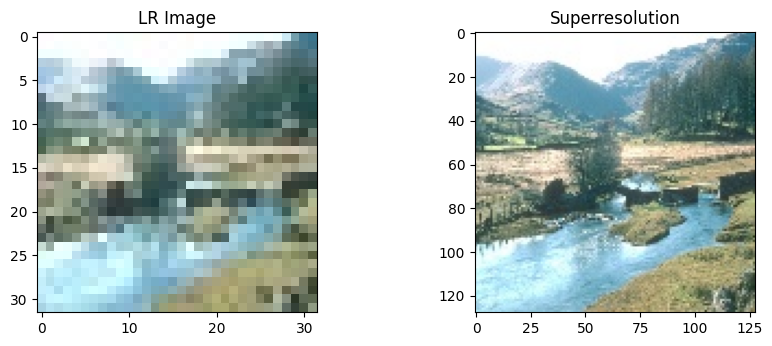

In [78]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)   #load the saved model
[X1, X2] = [lr_images, hr_images]
# select random example
ix = randint(0, len(X1), 1)
gen_image=hr_images[ix]

#source image and target image
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
genn_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])

plt.show()

